<a href="https://colab.research.google.com/github/WaiWasabi/tensorflow-certification-prep/blob/main/Transfer%20Learning%20and%20Fine%20Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# Download Images and Create Dataset

In [ ]:
url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path = tf.keras.utils.get_file('cats_and_dogs.zip', origin=url, extract=True)
PATH = os.path.join(os.path.dirname(path), 'cats_and_dogs_filtered')
train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'validation')

IMG_SIZE = (160, 160)
BATCH_SIZE = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, shuffle=True, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(val_dir, shuffle=True, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
labels = train_ds.class_names

# Visualize Data

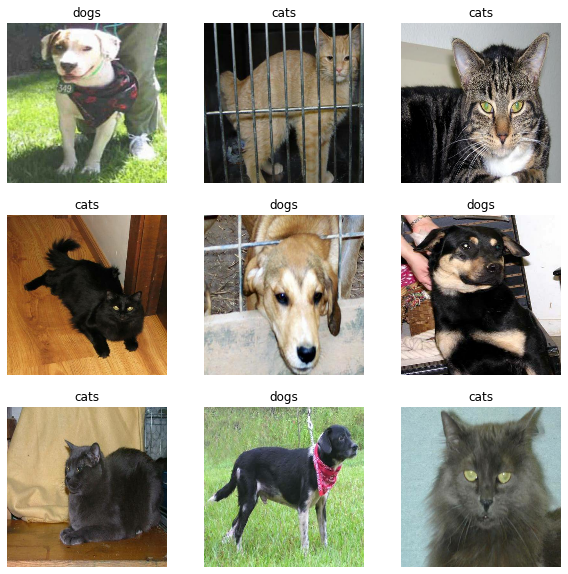

In [ ]:
plt.figure(figsize=(10,10))
for image, label in train_ds.take(1): 
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(str(labels[label[i]]))
    plt.axis('off')

# Create Test Dataset

In [ ]:
val_batches = int(val_ds.cardinality())
test_ds = val_ds.take(val_batches//5)
val_ds = val_ds.skip(val_batches//5)

# Configure for Performance

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds.prefetch(buffer_size=AUTOTUNE)
val_ds.prefetch(buffer_size=AUTOTUNE)

<PrefetchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>

# Data Augmentation and Rescaling

In [ ]:
data_augmentation = tf.keras.models.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)],
  name="data_augmentation")

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)

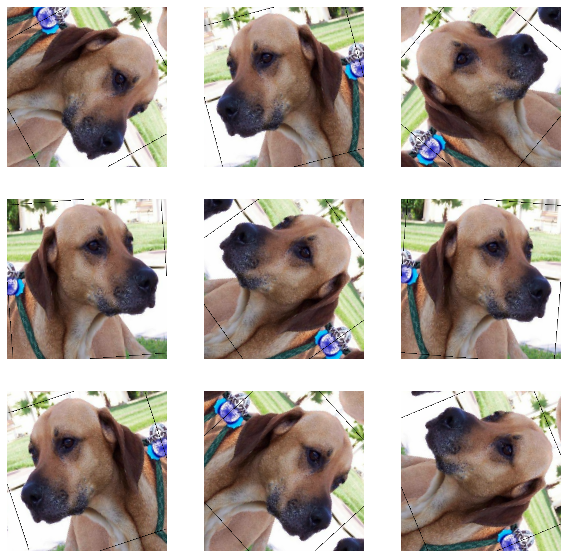

In [ ]:
plt.figure(figsize=(10,10))
for image, _ in train_ds.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(tf.squeeze(data_augmentation(tf.expand_dims(image[0], 0)))/255)
    plt.axis('off')

# Create Base Model with Pretrained Network

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [ ]:
image, label = next(iter(train_ds))
output = base_model(image)
print(output.shape) # get output shape of feature extractor

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False  # freezes trainable variables during training. VERY IMPORTANT!

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

# Add Classification Head

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # Average feature maps into scalars.
test = global_average_layer(output)
print("GlobalAveragePooling output shape:", test.shape)

prediction_layer = tf.keras.layers.Dense(1)
batch_predication_test = prediction_layer(test)
print("Dense layer prediction shape:", batch_predication_test.shape)

GlobalAveragePooling output shape: (32, 1280)
Dense layer prediction shape: (32, 1)


# Build Model using Keras Functional API

In [ ]:
inputs = tf.keras.layers.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Compile and Fit

In [ ]:
base_learning_rate=0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, 160, 160, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

In [ ]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
63/63 [==============================] - 58s 928ms/step - loss: 0.6723 - accuracy: 0.6155 - val_loss: 0.4657 - val_accuracy: 0.7760
Epoch 2/10
63/63 [==============================] - 58s 916ms/step - loss: 0.5054 - accuracy: 0.7320 - val_loss: 0.3464 - val_accuracy: 0.8453
Epoch 3/10
63/63 [==============================] - 58s 917ms/step - loss: 0.4050 - accuracy: 0.8055 - val_loss: 0.2678 - val_accuracy: 0.9010
Epoch 4/10
63/63 [==============================] - 58s 927ms/step - loss: 0.3492 - accuracy: 0.8390 - val_loss: 0.2266 - val_accuracy: 0.9307
Epoch 5/10
63/63 [==============================] - 59s 939ms/step - loss: 0.2988 - accuracy: 0.8620 - val_loss: 0.2004 - val_accuracy: 0.9381
Epoch 6/10
63/63 [==============================] - 58s 925ms/step - loss: 0.2875 - accuracy: 0.8645 - val_loss: 0.1718 - val_accuracy: 0.9505
Epoch 7/10
63/63 [==============================] - 59s 930ms/step - loss: 0.2498 - accuracy: 0.8980 - val_loss: 0.1580 - val_accuracy: 0.9530

# Plot Loss and Accuracy

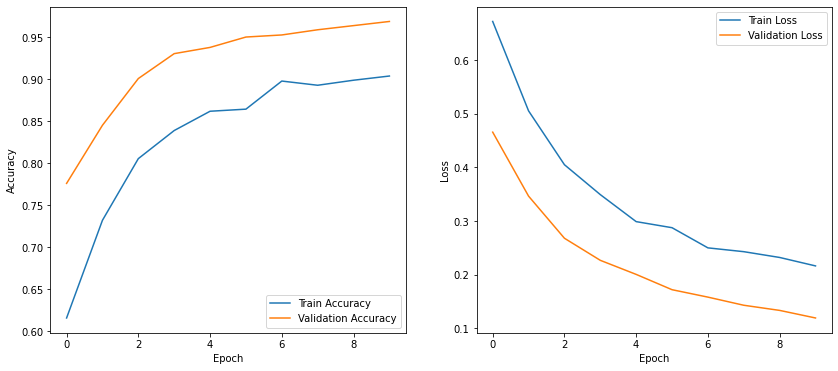

In [ ]:
plt.figure(figsize=(14,6))
ax = plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()